##### Imports

In [1]:
# %pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

# Loading Saved Model

In [ ]:
def load_and_analyze_KAMA_MSR_model(asset_name: str, n_regimes: int, sub_folder: str, edte_sub_folder: str) -> None:
    pkl_file_path = f'saved_models/KAMA_MSR/{sub_folder}/{edte_sub_folder}/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes.pkl'
    with open(pkl_file_path, 'rb') as f:
        loaded_model = pickle.load(f)

    print("="*80)
    print("LOADED MODEL INFORMATION")
    print("="*80)

    # ============================================================================
    # 2. ACCESS KAMA PARAMETERS
    # ============================================================================
    print("\n2. KAMA PARAMETERS:")
    print("-" * 40)
    print(f"KAMA n: {loaded_model.kama.n}")
    print(f"KAMA n_fast: {loaded_model.kama.n_fast}")
    print(f"    KAMA k_fast: {loaded_model.kama.k_fast:.6f}")
    print(f"KAMA n_slow: {loaded_model.kama.n_slow}")
    print(f"    KAMA k_slow: {loaded_model.kama.k_slow:.6f}")
    print(f"gamma: {loaded_model.gamma}")

    # ============================================================================
    # 3. ACCESS PRIORS (AFTER OPTIMIZATION)
    # ============================================================================
    print("\n3. MSR PRIORS:")
    print("-" * 40)

    # The priors used during model initialization
    priors = loaded_model.msr.priors
    for param, value in priors.items():
        print(f"{param}: {value}")

    # ============================================================================
    # 4. ACCESS MODEL CONFIGURATION
    # ============================================================================
    print("\n4. MODEL CONFIGURATION:")
    print("-" * 40)
    print(f"use_three_state_msr: {loaded_model.use_three_state_msr}")
    print(f"Number of combined regimes: {loaded_model.n_combined_regimes}")
    print(f"MSR n_regimes: {loaded_model.msr.n_regimes}")

    # ============================================================================
    # 5. CHECK DATA DIMENSIONS
    # ============================================================================
    print("\n5. DATA INFORMATION:")
    print("-" * 40)
    if loaded_model.prices is not None:
        print(f"Price data length: {len(loaded_model.prices)}")
        print(f"Return data length: {len(loaded_model.returns)}")
        print(f"Regime labels length: {len(loaded_model.regime_labels.dropna())}")
        print(f"Regime changes: {(loaded_model.regime_labels.diff() != 0).sum()}")

    # ============================================================================
    # 6. ACCESS MSR PARAMETERS (AFTER FITTING)
    # ============================================================================
    print("\n6. MSR PARAMETERS (Post-Fit):")
    print("-" * 40)
    print("MSR Means (μ):")
    for i, mean in enumerate(loaded_model.msr.means):
        print(f"  Regime {i}: {mean:.6f}")

    print("\nMSR Betas (β):")
    for i, beta in enumerate(loaded_model.msr.betas):
        print(f"  Regime {i}: {beta:.4f}")

    print("\nMSR Standard Deviations (σ):")
    for i, std in enumerate(loaded_model.msr.stds):
        print(f"  Regime {i}: {std:.6f}")

    print("\nMSR Transition Probabilities:")
    print("          To Regime:")
    print("From      0       1" + ("       2" if loaded_model.msr.n_regimes == 3 else ""))
    print("Regime")
    for i in range(loaded_model.msr.n_regimes):
        row = f"  {i}    "
        for j in range(loaded_model.msr.n_regimes):
            row += f"  {loaded_model.msr.transition_probs[i,j]:.3f}"
        print(row)


    # ============================================================================
    # 7. RUN ANALYSIS ON LOADED MODEL
    # ============================================================================
    print("\n7. RUNNING FULL ANALYSIS ON LOADED MODEL...")
    loaded_model.analyze_results(data_name=asset_name)
    regime_duration_stats = loaded_model.analyze_regime_durations()
    print("\nRegime Duration Statistics:")
    print(regime_duration_stats)
    loaded_model.regime_characteristics(data_name=asset_name)
    loaded_model.plot_regimes(data_name=asset_name)
    # loaded_model.plot_regime_duration_distribution()
    loaded_model.plot_comprehensive_analysis(data_name=asset_name)
    loaded_model.diagnostics(data_name=asset_name, trace_plots=False)
    
    return loaded_model

asset_name = 'S&P 500'
n_regimes = 2
sub_folder = 'us_bond'
edte_sub_folder = datetime(2022, 1, 1).strftime('%Y%m%d')
loaded_model = load_and_analyze_KAMA_MSR_model(asset_name, n_regimes, sub_folder, edte_sub_folder)

# More Plots

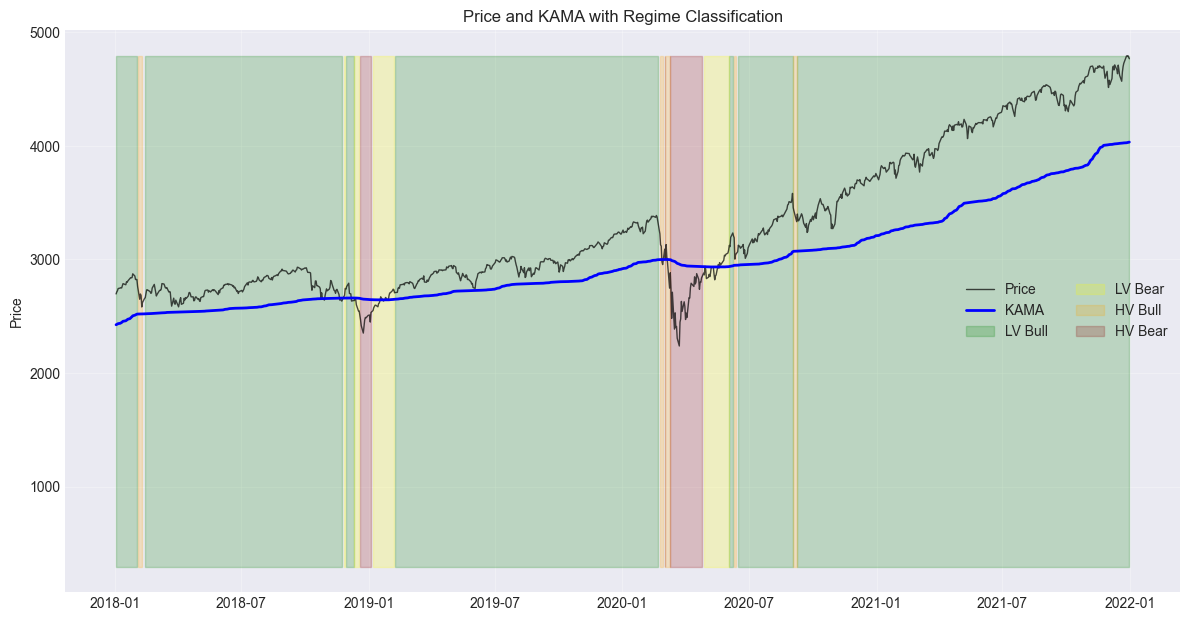

In [5]:
regime_labels_clean = loaded_model.regime_labels.dropna()

sdte = datetime(2018, 1, 1)
edte = datetime(2022, 12, 31)
regime_labels_clean = regime_labels_clean.loc[sdte:edte]
prices = loaded_model.prices.loc[regime_labels_clean.index]
kama_values = loaded_model.kama_values.loc[regime_labels_clean.index]

fig = plt.figure(figsize=(12, 24))

if loaded_model.use_three_state_msr:
    colors = {0: 'green', 1: 'blue', 2: 'yellow',
             3: 'orange', 4: 'purple', 5: 'red'}
    regime_names = {0: 'LV Bull', 1: 'LV Bear', 2: 'MV Bull',
                   3: 'MV Bear', 4: 'HV Bull', 5: 'HV Bear'}
else:
    colors = {0: 'green', 1: 'yellow', 2: 'orange', 3: 'darkred'}
    regime_names = {0: 'LV Bull', 1: 'LV Bear', 2: 'HV Bull', 3: 'HV Bear'}

# Plot 1: Price and KAMA
ax1 = fig.add_subplot(411)
ax1.plot(prices.index, prices, label='Price', 
        color='black', alpha=0.7, linewidth=1)
ax1.plot(kama_values.index, kama_values, 
        label='KAMA', color='blue', linewidth=2)

for regime in range(loaded_model.n_combined_regimes):
    mask = (regime_labels_clean == regime)
    if mask.any():
        mask_aligned = pd.Series(False, index=loaded_model.prices.index)
        mask_aligned.loc[regime_labels_clean.index[mask]] = True
        
        ax1.fill_between(loaded_model.prices.index, loaded_model.prices.min(), loaded_model.prices.max(),
                       where=mask_aligned.values, alpha=0.2, color=colors[regime],
                       label=regime_names[regime])

ax1.set_title('Price and KAMA with Regime Classification')
ax1.set_ylabel('Price')
ax1.legend(loc='best', ncol=2)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
